In [1]:
from zipfile import ZipFile
zf = ZipFile('dataset_face_mask.zip')
zf.extractall('sample_data') #save files in selected folder
zf.close()

In [5]:
pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25872 sha256=0cfc09dd4ac596a0b31db04eb2509cdcfa2d10fb71dba82bffee7af5ce5433df
  Stored in directory: c:\users\being\appdata\local\pip\cache\wheels\4b\a5\2d\4a070a801d3a3d93f033d3ee9728f470f514826e89952df3ea
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import numpy as np
import random
import keras

from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

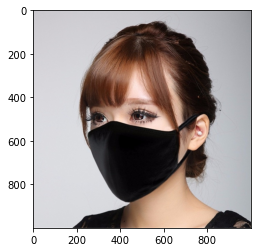

In [3]:
images_withMask = os.listdir("sample_data/New Masks Dataset/Train/Mask")
sample_img_withMask = random.choice(images_withMask)
image = load_img("sample_data/New Masks Dataset/Train/Mask/"+sample_img_withMask)
plt.imshow(image)

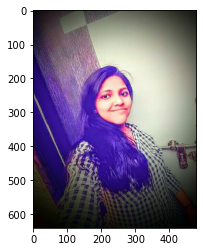

In [4]:
images_withoutMask = os.listdir("sample_data/New Masks Dataset/Train/Non Mask")
sample_img_withoutMask = random.choice(images_withoutMask)
image = load_img("sample_data/New Masks Dataset/Train/Non Mask/"+sample_img_withoutMask)
plt.imshow(image)

In [5]:

img_width=224
img_height=224

INIT_LR = 1e-4
EPOCHS = 50
BS = 32
train_data_dir="sample_data/New Masks Dataset/Train"
test_data_dir="sample_data/New Masks Dataset/Validation"

In [6]:
all_train_imagePaths = list(paths.list_images(train_data_dir))
all_test_imagePaths = list(paths.list_images(test_data_dir))
train_data = []
train_labels = []
test_data = []
test_labels = []

In [7]:

for imagePath in all_train_imagePaths:

	label = imagePath.split(os.path.sep)[-2]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	train_data.append(image)
	train_labels.append(label)

In [8]:
for imagePath in all_test_imagePaths:
	label = imagePath.split(os.path.sep)[-2]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	test_data.append(image)
	test_labels.append(label)

In [9]:
def convert_data_labels(data,labels):
  data = np.array(data, dtype="float32")
  labels = np.array(labels)
  lb = LabelBinarizer()
  labels = lb.fit_transform(labels)
  labels = to_categorical(labels)
  return  data,labels

In [10]:
train_data,train_labels = convert_data_labels(train_data,train_labels)
test_data,test_labels = convert_data_labels(test_data,test_labels)

In [11]:
print("==================================")
print("Size of train dataset : ",train_data.shape[0])
print("==================================")
print("Size of test dataset : ",test_data.shape[0])
print("==================================")

Size of train dataset :  600
Size of test dataset :  306


In [12]:

train_datagen = ImageDataGenerator(
                  rotation_range=20,
                  zoom_range=0.15,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  shear_range=0.15,
                  horizontal_flip=True,
                  fill_mode="nearest")

train_generator = train_datagen.flow(train_data, train_labels, batch_size=BS)

In [13]:
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [14]:

headModel = mobilenet.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [15]:
model = Model(inputs=mobilenet.input, outputs=headModel)

In [16]:

print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Done !!")


[INFO] compiling model...
Done !!


In [17]:

for layer in mobilenet.layers:
	layer.trainable = False

In [18]:

from datetime import datetime
def timer(start_time= None):
  if not start_time:
    start_time=datetime.now()
    return start_time
  elif start_time:
    thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
    tmin,tsec=divmod(temp_sec,60)
    print('\n Time taken: %i hours %i minutes and %s seconds. '% (thour,tmin,round(tsec,2)))

In [19]:

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)


checkPoint = keras.callbacks.ModelCheckpoint(filepath="/content/sample_data/fmd_model.h5",
                             monitor='val_loss',
                             mode='auto',
                             save_best_only=True,
                             verbose=1)


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [20]:
callbacks = [earlystop , checkPoint, learning_rate_reduction]

In [ ]:
start_time=timer(None)
classifier = model.fit(
    train_datagen.flow(train_data, train_labels, batch_size=BS), 
    epochs=EPOCHS,
    validation_data=(test_data,test_labels),
    validation_steps=len(test_data)//BS,
    steps_per_epoch=len(train_data)//BS,
    callbacks=callbacks
)
timer(start_time)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.4844 - accuracy: 0.8486
Epoch 1: val_loss improved from inf to 0.42625, saving model to /content/sample_data\fmd_model.h5
18/18 [==============================] - 51s 2s/step - loss: 0.4844 - accuracy: 0.8486 - val_loss: 0.4262 - val_accuracy: 0.7549 - lr: 1.0000e-04
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.9688
Epoch 2: val_loss improved from 0.42625 to 0.35144, saving model to /content/sample_data\fmd_model.h5
18/18 [==============================] - 45s 3s/step - loss: 0.1712 - accuracy: 0.9688 - val_loss: 0.3514 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.0692 - accuracy: 0.9930
Epoch 3: val_loss improved from 0.35144 to 0.26581, saving model to /content/sample_data\fmd_model.h5
18/18 [==============================] - 45s 3s/step - loss: 0.0692 - accuracy: 0.9930 - val_loss: 0.2658 - val_accuracy: 0.

18/18 [==============================] - 47s 3s/step - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.0560 - val_accuracy: 0.9869 - lr: 1.0000e-05
Epoch 25/50
18/18 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000
Epoch 25: val_loss improved from 0.05597 to 0.05326, saving model to /content/sample_data\fmd_model.h5
18/18 [==============================] - 47s 3s/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0533 - val_accuracy: 0.9902 - lr: 1.0000e-05
Epoch 26/50
18/18 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000
Epoch 26: val_loss improved from 0.05326 to 0.05188, saving model to /content/sample_data\fmd_model.h5
18/18 [==============================] - 47s 3s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9902 - lr: 1.0000e-05
Epoch 27/50
18/18 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000
Epoch 27: val_loss improved from 0.05188 to 0.05107, saving model to /c

Epoch 49/50
12/18 [===================>..........] - ETA: 15s - loss: 0.0012 - accuracy: 1.0000

In [ ]:

plt.style.use("ggplot")
N = 10
plt.figure()
plt.plot( classifier.history["loss"], label="train_loss")
plt.plot( classifier.history["val_loss"], label="val_loss")
plt.plot( classifier.history["accuracy"], label="train_acc")
plt.plot( classifier.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")

In [ ]:

print("[INFO] evaluating network...")
predIdxs = model.predict(test_data, batch_size=BS)

In [ ]:

predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:

val_loss,val_acc = model.evaluate(test_data,test_labels)
print("=======================================================")
print("Accuracy is : ",val_acc)
print("=======================================================")
print("Loss is : ",val_loss)
print("=======================================================")

In [ ]:

print(classification_report(test_labels.argmax(axis=1), predIdxs))